## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import logging
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from tqdm.autonotebook import tqdm

import amp_research.price_movement_analysis as pma
import helpers.dbg as dbg
import helpers.env as env
import helpers.printing as pri
import helpers.s3 as hs3
import vendors.cme.read as cmer
import vendors.kibot.utils as kut

/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
print(env.get_system_signature())

pri.config_notebook()

dbg.init_logger(verb=logging.INFO)

_LOG = logging.getLogger(__name__)

# Packages
         python: 3.7.3
         joblib: 0.13.2
          numpy: 1.16.4
         pandas: 0.24.2
        pyarrow: - (can't import)
          scipy: 1.3.0
        seaborn: 0.9.0
        sklearn: 0.21.2
    statsmodels: 0.10.0
# Last commits:
  * 4b089e0 Julia    PartTask218: Change order to ascending for negative movements     (21 minutes ago) Wed Oct 16 19:00:42 2019  (HEAD -> PartTask218_PRICE_Large_price_movement_analysis, origin/PartTask218_PRICE_Large_price_movement_analysis)
  * ffd4e3e Julia    PartTask218: Update for the removed abs in get_zscored_returns(), choose sign of the movements (32 minutes ago) Wed Oct 16 18:49:53 2019           
  * 1bfbfcd Julia    PartTask218: Divide positive and negative movements               (   2 hours ago) Wed Oct 16 17:42:08 2019           


# Load CME metadata

In [4]:
product_list = cmer.read_product_specs()

Reading s3://default00-bucket/cme/product_slate_export_with_contract_specs_20190905.csv


In [5]:
product_list.head()

,Clearing,Globex,Floor,Clearport,Product Name,Product Group,Sub Group,Category,Sub Category,Cleared As,Exchange,Volume,Open Interest,product_link,Contract Unit,Price Quotation,Trading Hours,Minimum Price Fluctuation,Product Code,Listed Contracts,Settlement Method,Termination Of Trading,Settlement Procedures,Position Limits,Exchange Rulebook,Block Minimum,Price Limit Or Circuit,All Or None Minimum,Vendor Codes,Settlement Procedures Link,Position Limits Link,Exchange Rulebook Link,Block Minimum Link,Price Limit Or Circuit Link,All Or None Minimum Link,Vendor Codes Link,Delivery Procedure,Last Delivery Date,Grade And Quality,Trade At Marker Or Trade At Settlement Rules,Delivery Period,Minimum Price Fluctuation_0,Grade And Quality Link,Floating Price,Days Or Hours,Trading Hours_0,Delivery Period Link,Delivery Procedure Link,Trade At Marker Or Trade At Settlement Rules Link,Minimum Price Fluctuation Link,Listed Contracts Link,Termination Of Trading_0,Termination Of Trading Link,Reportable Positions,Termination Of Trading_1,CME Globex:,Reportable Positions Link
0,ED,GE,NaN,ED,Eurodollar Futures,Interest Rate,Stirs,NaN,NaN,Futures,CME,3104281,13213901,http://www.cmegroup.com/trading/interest-rates...,"$2,500 x Contract IMM Index",Contract IMM Index = 100 minus R R = three-mon...,SUN - FRI: 5:00 p.m. - 4:00 p.m. CT,Nearest expiring contract month: One quarter o...,CME Globex: GECME ClearPort: EDClearing: ED,"Nearest 40 months (i.e., 10 years) in the Marc...",Financially Settled,Second London bank business day before 3rd Wed...,Eurodollar Future Settlement Procedures,CME Position Limits,CME 452,Block Minimum Thresholds,Price Limits,All or None Minimums,Quote Vendor Symbols Listing,http://www.cmegroup.com/confluence/display/EPI...,http://www.cmegroup.com/rulebook/files/positio...,http://www.cmegroup.com/rulebook/CME/V/450/452...,http://www.cmegroup.com/clearing/trading-pract...,http://www.cmegroup.com/rulebook/files/special...,http://www.cmegroup.com/clearing/trading-pract...,http://www.cmegroup.com/tools-information/vend...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,ZF,NaN,25,5-Year T-Note Futures,Interest Rate,US Treasury,NaN,NaN,Futures,CBOT,1166719,4162661,http://www.cmegroup.com/trading/interest-rates...,"Face value at maturity of $100,000",Points and fractions of points with par on the...,SUN - FRI: 5:00 p.m. - 4:00 p.m.,One-quarter of one thirty-second (1/32) of one...,CME Globex: ZFCME ClearPort: 25Clearing: 25,The first three consecutive contracts in the M...,Deliverable,Last business day of the calendar month. Tradi...,Treasury Settlement Procedures,CBOT Position Limits,CBOT 20,Block Minimum Thresholds,Price Limits,All or None Minimums,Quote Vendor Symbols Listing,http://www.cmegroup.com/confluence/display/EPI...,http://www.cmegroup.com/rulebook/files/positio...,https://www.cmegroup.com/rulebook/CBOT/II/20.pdf,http://www.cmegroup.com/clearing/trading-pract...,http://www.cmegroup.com/rulebook/files/special...,/clearing/trading-practices/all-or-none.html,http://www.cmegroup.com/tools-information/vend...,Federal Reserve book-entry wire-transfer system.,Third business day following the last trading ...,U.S. Treasury notes with an original term to m...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21,ZN,NaN,21,10-Year T-Note Futures,Interest Rate,US Treasury,NaN,NaN,Futures,CBOT,2181982,3656744,http://www.cmegroup.com/trading/interest-rates...,"Face value at maturity of $100,000",Points and fractions of points with par on the...,Sunday - Friday 6:00 p.m. - 5:00 p.m. (5:00 p....,Outrights: One-half of one thirty-second (1/32...,CME Globex: ZNCME ClearPort: 21Clearing: 21,"Quarterly contracts (Mar, Jun, Sep, Dec) liste...",Deliverable,Trading terminates on the seventh business day...,Treasury Settlement Procedures,CBOT Position Limits,CBOT Chapter 19,Block Minimum Thresholds,Price Limits,All or None Minimums,Quote Vendor Symbols Listing,http://www.cmegroup.com/

In [6]:
product_list["Product Group"].value_counts()

Energy           892
Equities         100
Agriculture       57
FX                55
Metals            44
Interest Rate     30
Name: Product Group, dtype: int64

In [7]:
product_list.set_index("Product Group", inplace=True)

In [8]:
commodity_groups = ["Energy", "Agriculture", "Metals"]

In [9]:
commodity_symbols = {
    group: product_list.loc[group]["Globex"].values for group in commodity_groups
}

In [10]:
commodity_symbols

{'Energy': array(['CL', 'NG', 'NN', 'N9L', 'D2L', 'HO', 'RB', 'H2L', 'HH', 'BZ',
        'V3L', 'BK', 'CSX', 'HTT', 'B0', 'NPG', 'WTT', 'B6L', 'E4L', 'HP',
        'AL1', 'AFF', 'EJL', 'LT', 'AD0', 'A1R', 'R7L', 'D4L', 'AW6', 'CU',
        'ADB', 'AC0', 'L3L', 'A4P', 'ME', 'CY', 'WOL', 'A8K', 'T7K', 'ZGL',
        'MTF', 'LPS', 'T3L', 'AE5', 'AYV', 'MFB', 'AU6', 'RBB', 'AWJ',
        'POL', 'A7Q', 'IDL', 'PWL', 'AZ9', 'RVR', 'ZJL', 'TL', 'A46', 'GZ',
        'RLX', 'K4L', 'FTL', 'HOB', 'GCU', 'CRB', 'WCW', 'AOL', 'JDL',
        'EN', 'AA6', 'PD', 'AGA', 'FO', 'N1B', 'NOI', 'MPX', 'NHN', 'NL',
        'JKM', 'MTS', 'AB3', 'NR', 'AH3', 'AP8', 'A7E', 'PGN', 'AFH',
        'AZ1', 'A8I', 'MNC', 'UV', 'SE', 'MAF', 'B7H', 'J4L', 'AYX', 'QM',
        'D3L', 'IN', 'MEO', 'QG', 'EXR', 'PM', 'TTF', 'MFF', 'PGG', 'D7L',
        'BOO', 'MXB', 'EVC', 'A5C', 'AA8', 'EWG', 'HB', 'A8O', 'RKA',
        'ARE', 'GCI', 'A1M', 'AL6', 'A1L', 'A0D', 'MBR', 'APS', 'N3L',
        'JET', 'VR', 'A9N', 'PH', 'PEL'

# Daily price movements

## Load kibot commodity daily prices

In [11]:
daily_metadata = kut.read_metadata2()
daily_metadata.head(3)

,Symbol,Link,Description
All_Futures_Contracts_daily.csv,,,
1,JY,http://api.kibot.com/?action=download&link=151...,CONTINUOUS JAPANESE YEN CONTRACT
2,JYF18,http://api.kibot.com/?action=download&link=vrv...,JAPANESE YEN JANUARY 2018
3,JYF19,http://api.kibot.com/?action=download&link=8r8...,JAPANESE YEN JANUARY 2019


In [12]:
len(daily_metadata["Symbol"])

14962

In [13]:
daily_metadata["Symbol"].nunique()

14962

In [14]:
len(commodity_symbols["Energy"])

892

In [15]:
energy_symbols_kibot = np.intersect1d(
    daily_metadata["Symbol"].values, commodity_symbols["Energy"]
)
energy_symbols_kibot

array(['ALM', 'BB', 'BZ', 'CCM', 'CL', 'FRC', 'HO', 'IN', 'JE', 'LL',
       'ME', 'MME', 'NG', 'NN', 'PM', 'QG', 'QM', 'RB', 'STS', 'TC', 'TL',
       'TM', 'TW'], dtype=object)

In [16]:
len(energy_symbols_kibot)

23

In [17]:
commodity_symbols_kibot = {
    group: np.intersect1d(
        daily_metadata["Symbol"].values, commodity_symbols[group]
    )
    for group in commodity_symbols.keys()
}

In [18]:
commodity_symbols_kibot

{'Energy': array(['ALM', 'BB', 'BZ', 'CCM', 'CL', 'FRC', 'HO', 'IN', 'JE', 'LL',
        'ME', 'MME', 'NG', 'NN', 'PM', 'QG', 'QM', 'RB', 'STS', 'TC', 'TL',
        'TM', 'TW'], dtype=object),
 'Agriculture': array(['GF', 'HE', 'LE', 'TT', 'ZCT', 'ZLT', 'ZMT', 'ZWT'], dtype=object),
 'Metals': array(['GC', 'GCK', 'HG', 'HGT', 'MGC', 'PA', 'PL', 'QC', 'QI', 'QO',
        'SI', 'SIL', 'UX'], dtype=object)}

In [19]:
{
    group: len(commodity_symbols_kibot[group])
    for group in commodity_symbols_kibot.keys()
}

{'Energy': 23, 'Agriculture': 8, 'Metals': 13}

In [20]:
comm_list = []
for comm_group in commodity_symbols_kibot.values():
    comm_list.extend(list(comm_group))
comm_list[:5]

['ALM', 'BB', 'BZ', 'CCM', 'CL']

In [21]:
len(comm_list)

44

In [22]:
s3_path = hs3.get_path()
kibot_path = os.path.join(
    s3_path, "kibot/All_Futures_Continuous_Contracts_daily/%s.csv.gz"
)

daily_price_dict_df = kut.read_multiple_symbol_data(
    comm_list, kibot_path, nrows=None
)

daily_price_dict_df["CL"].tail(2)

args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_daily/ALM.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_daily/BB.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_daily/BZ.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_daily/CCM.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_daily/CL.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_daily/FRC.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_daily/HO.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_daily/IN.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_daily/JE.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_daily/LL.cs

,open,high,low,close,vol
date,,,,,
2019-07-18,56.72,57.45,54.85,55.42,764491
2019-07-19,55.84,56.49,55.12,55.76,710948


## Largest movements for a specific symbol

In [23]:
symbol = "CL"

In [24]:
tau = 18

top_daily_movements_cl = pma.get_top_movements_for_symbol(
    daily_price_dict_df, symbol, "daily", tau, 'all'
)
top_daily_movements_cl.head()

date
2014-12-01    3.655719
2001-11-16    3.645029
2001-09-25    3.515338
2002-03-18    3.365737
2011-05-06    3.333398
Name: ret_0, dtype: float64

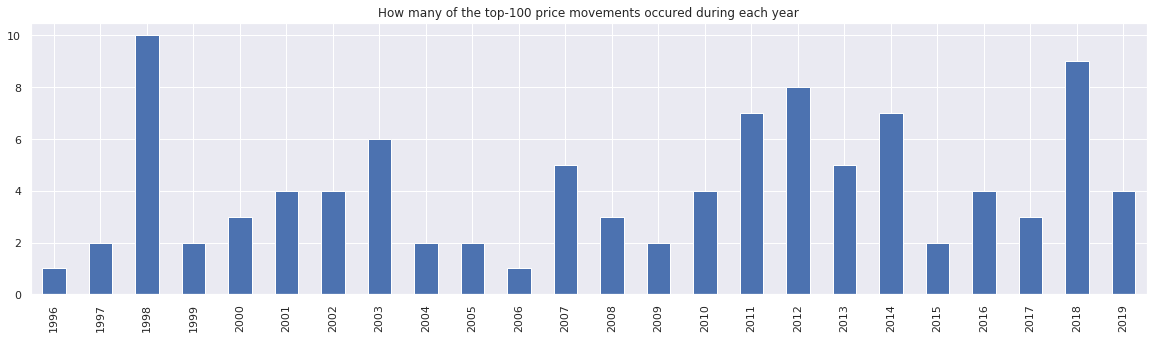

In [25]:
top_daily_movements_cl.index.year.value_counts(sort=False).plot(kind="bar")
plt.title("How many of the top-100 price movements occured during each year")
plt.show()

In [26]:
top_pos_daily_movements_cl = pma.get_top_movements_for_symbol(
    daily_price_dict_df, symbol, "daily", tau, 'pos')
top_pos_daily_movements_cl.head()

date
2002-03-18    3.365737
2001-09-14    3.258836
1998-12-17    2.981000
1998-01-27    2.967284
2015-08-28    2.834156
Name: ret_0, dtype: float64

In [27]:
top_neg_daily_movements_cl = pma.get_top_movements_for_symbol(
    daily_price_dict_df, symbol, "daily", tau, 'neg')
top_neg_daily_movements_cl.head()

date
2014-12-01   -3.655719
2001-11-16   -3.645029
2001-09-25   -3.515338
2011-05-06   -3.333398
2003-07-23   -3.011276
Name: ret_0, dtype: float64

## Largest movement for energy group

In [28]:
group = "Energy"

In [29]:
commodity_symbols_kibot[group]

array(['ALM', 'BB', 'BZ', 'CCM', 'CL', 'FRC', 'HO', 'IN', 'JE', 'LL',
       'ME', 'MME', 'NG', 'NN', 'PM', 'QG', 'QM', 'RB', 'STS', 'TC', 'TL',
       'TM', 'TW'], dtype=object)

In [30]:
tau = 18

pma.get_top_movements_by_group(
    daily_price_dict_df, commodity_symbols_kibot, group, "daily", tau, 'all'
).head(15)

/wd/julia/commodity_research/amp/vendors/kibot/utils.py:191: RuntimeWarning: divide by zero encountered in log
  ret_0 = np.log(prices) - np.log(prices.shift(1))
/wd/julia/commodity_research/amp/vendors/kibot/utils.py:191: RuntimeWarning: invalid value encountered in log
  ret_0 = np.log(prices) - np.log(prices.shift(1))


date
1999-03-11    2.535575
1996-01-08    2.498073
1995-12-11    2.272908
2004-11-25    2.224133
1998-03-19    2.197773
1998-01-27    2.154381
1996-01-12    2.107268
2011-08-05    2.095441
1997-09-26    2.040933
2002-05-16    2.033812
1997-08-05    1.979685
1996-05-24    1.971286
1997-09-29    1.958196
2010-11-28    1.956024
1995-12-05    1.951210
dtype: float64

In [31]:
pma.get_top_movements_by_group(
    daily_price_dict_df, commodity_symbols_kibot, group, "daily", tau, 'pos'
).head(15)

date
1998-01-27    2.914811
1997-08-29    2.564230
1999-03-11    2.535575
2003-06-27    2.514636
1996-01-08    2.498073
1998-08-06    2.389564
2008-10-16    2.352955
1997-10-06    2.327103
1995-12-11    2.272908
2003-10-30    2.223610
1998-03-19    2.197773
2000-09-25    2.170945
1999-07-01    2.170499
1997-05-13    2.168076
1999-03-18    2.118684
dtype: float64

In [32]:
pma.get_top_movements_by_group(
    daily_price_dict_df, commodity_symbols_kibot, group, "daily", tau, 'neg'
).head(15)

date
1999-05-11   -3.659869
1996-05-28   -2.864218
1996-07-19   -2.810977
2002-02-28   -2.741013
2003-02-21   -2.725156
2004-11-25   -2.647316
2000-12-13   -2.578835
1996-12-30   -2.556659
2011-08-05   -2.510363
1998-07-22   -2.504371
1998-03-17   -2.492691
2001-11-16   -2.404971
1998-08-11   -2.394507
1996-03-25   -2.390299
2008-10-14   -2.389227
dtype: float64

## Largest movements for each group

In [33]:
tau = 18

top_100_daily_movements_by_group = {
    group: pma.get_top_movements_by_group(
        daily_price_dict_df, commodity_symbols_kibot, group, "daily", tau, 'all'
    )
    for group in tqdm(commodity_symbols_kibot.keys())
}

In [34]:
{
    group: head_prices_group.head(15)
    for group, head_prices_group in top_100_daily_movements_by_group.items()
}

{'Energy': date
 1999-03-11    2.535575
 1996-01-08    2.498073
 1995-12-11    2.272908
 2004-11-25    2.224133
 1998-03-19    2.197773
 1998-01-27    2.154381
 1996-01-12    2.107268
 2011-08-05    2.095441
 1997-09-26    2.040933
 2002-05-16    2.033812
 1997-08-05    1.979685
 1996-05-24    1.971286
 1997-09-29    1.958196
 2010-11-28    1.956024
 1995-12-05    1.951210
 dtype: float64, 'Agriculture': date
 2019-03-18    2.606163
 2003-12-29    2.503282
 2013-09-02    2.406208
 2016-09-05    2.352189
 2014-05-26    2.170093
 2009-04-16    2.136641
 2013-04-01    2.117786
 2005-08-15    2.089122
 2006-05-01    2.081217
 2003-09-22    2.079330
 2011-02-15    2.050200
 2002-04-04    2.049195
 2011-08-15    2.000392
 2008-01-14    1.987069
 2003-07-23    1.986694
 dtype: float64, 'Metals': date
 2007-12-02    3.582814
 2013-04-15    2.816036
 2013-04-16    2.735094
 2013-07-04    2.715543
 2007-02-19    2.699586
 1999-09-29    2.697176
 2001-09-14    2.629436
 2011-05-30    2.624040
 20

# 1-minute price movements

## Load 1-minute prices

In [35]:
minutely_metadata = kut.read_metadata1()

In [36]:
minutely_metadata.head()

,Symbol,Link,Description
All_Futures_Contracts_1min.csv,,,
1,JY,http://api.kibot.com/?action=download&link=151...,CONTINUOUS JAPANESE YEN CONTRACT
2,JYF18,http://api.kibot.com/?action=download&link=vrv...,JAPANESE YEN JANUARY 2018
3,JYF19,http://api.kibot.com/?action=download&link=8r8...,JAPANESE YEN JANUARY 2019
4,JYG18,http://api.kibot.com/?action=download&link=vrv...,JAPANESE YEN FEBRUARY 2018
5,JYG19,http://api.kibot.com/?action=download&link=8r8...,JAPANESE YEN FEBRUARY 2019


In [37]:
np.array_equal(
    minutely_metadata["Symbol"].values, minutely_metadata["Symbol"].values
)

True

In [38]:
len(comm_list)

44

In [39]:
s3_path = hs3.get_path()
kibot_path = os.path.join(
    s3_path, "kibot/All_Futures_Continuous_Contracts_1min/%s.csv.gz"
)

minutely_price_dict_df = kut.read_multiple_symbol_data(
    comm_list, kibot_path, nrows=None
)

daily_price_dict_df["CL"].tail(2)

args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/ALM.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/BB.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/BZ.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/CCM.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/CL.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/FRC.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/HO.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/IN.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/JE.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/LL.csv.gz', Non

,open,high,low,close,vol
date,,,,,
2019-07-18,56.72,57.45,54.85,55.42,764491
2019-07-19,55.84,56.49,55.12,55.76,710948


In [40]:
minutely_price_dict_df["CL"].head()

,open,high,low,close,vol,time
datetime,,,,,,
2009-09-27 18:00:00,66.15,66.35,66.15,66.32,88,18:00:00
2009-09-27 18:01:00,66.36,66.49,66.35,66.37,124,18:01:00
2009-09-27 18:02:00,66.37,66.41,66.37,66.37,25,18:02:00
2009-09-27 18:03:00,66.37,66.42,66.37,66.42,33,18:03:00
2009-09-27 18:04:00,66.39,66.46,66.39,66.46,14,18:04:00


In [41]:
# five_min_price_dict_df = {
#     symbol: minutely_price_dict_df[symbol].resample("5Min").sum()
#     for symbol in minutely_price_dict_df.keys()
# }

## Top movements for a symbol

In [42]:
symbol = "CL"

In [43]:
top_100_movements_cl_1_min = pma.get_top_movements_for_symbol(
    minutely_price_dict_df, symbol, "minutely", tau, 'all'
)

In [44]:
top_100_movements_cl_1_min.head()

datetime
2011-02-17 01:16:00    4.300486
2015-12-16 18:00:00    4.300040
2014-08-17 18:00:00    4.299188
2016-03-16 18:00:00    4.298413
2017-01-17 19:19:00    4.298211
Name: ret_0, dtype: float64

In [45]:
pma.get_top_movements_for_symbol(
    minutely_price_dict_df, symbol, "minutely", tau, 'pos'
).head()

datetime
2011-02-17 01:16:00    4.300486
2015-12-16 18:00:00    4.300040
2016-03-16 18:00:00    4.298413
2017-01-17 19:19:00    4.298211
2016-12-15 19:04:00    4.296084
Name: ret_0, dtype: float64

In [46]:
pma.get_top_movements_for_symbol(
    minutely_price_dict_df, symbol, "minutely", tau, 'neg'
).head()

datetime
2014-08-17 18:00:00   -4.299188
2015-06-28 18:00:00   -4.296374
2013-09-15 18:00:00   -4.294100
2014-04-16 18:00:00   -4.292428
2014-09-17 18:00:00   -4.290428
Name: ret_0, dtype: float64

In [47]:
# top_100_movements_cl_5_min = pma.get_top_movements_for_symbol(
#     five_min_price_dict_df, symbol
# )

In [48]:
# top_100_movements_cl_5_min.head()

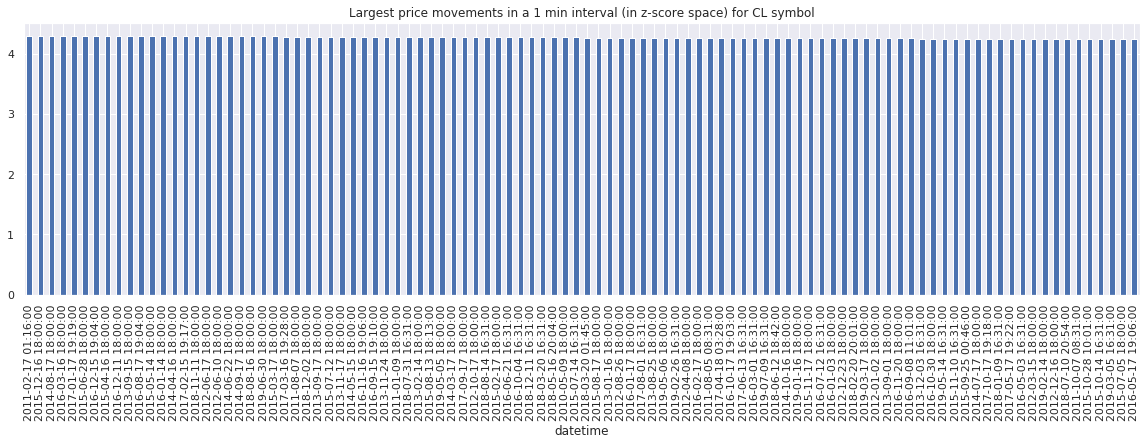

In [49]:
top_100_movements_cl_1_min.plot(kind="bar")
plt.title(
    f"Largest price movements in a 1 min interval (in z-score space) for {symbol} symbol"
)
plt.show()

In [50]:
print(f"Top 100 of the price movements for {symbol} occur at the following time:")
print(pd.Series(top_100_movements_cl_1_min.index).dt.time.value_counts())

Top 100 of the price movements for CL occur at the following time:
18:00:00    56
16:31:00    20
19:04:00     2
08:31:00     2
19:06:00     2
01:45:00     1
18:13:00     1
19:19:00     1
11:01:00     1
10:01:00     1
18:42:00     1
20:01:00     1
19:17:00     1
03:28:00     1
20:04:00     1
19:10:00     1
19:28:00     1
01:16:00     1
20:54:00     1
19:18:00     1
00:46:00     1
19:22:00     1
19:03:00     1
Name: datetime, dtype: int64


## Largest movements for energy group

In [51]:
group = "Energy"

In [52]:
commodity_symbols_kibot[group]

array(['ALM', 'BB', 'BZ', 'CCM', 'CL', 'FRC', 'HO', 'IN', 'JE', 'LL',
       'ME', 'MME', 'NG', 'NN', 'PM', 'QG', 'QM', 'RB', 'STS', 'TC', 'TL',
       'TM', 'TW'], dtype=object)

In [53]:
pma.get_top_movements_by_group(
    minutely_price_dict_df, commodity_symbols_kibot, group, "minutely", tau, 'all'
)

datetime
2012-01-16 14:06:00    4.298886
2015-02-12 17:59:00    4.288120
2016-09-15 19:10:00    4.282692
2018-01-01 04:31:00    4.261540
2017-09-13 17:55:00    4.253446
2019-05-06 17:00:00    4.245467
2019-04-03 17:56:00    4.243571
2017-03-29 17:02:00    4.243452
2019-02-08 17:17:00    4.233571
2017-08-17 19:22:00    4.231148
2018-12-07 17:59:00    4.216019
2016-08-30 17:07:00    4.213595
2018-02-20 17:06:00    4.212008
2010-01-20 18:45:00    4.206067
2011-04-22 13:15:00    4.202897
2016-06-16 19:03:00    4.202772
2019-06-25 17:57:00    4.191055
2015-03-05 17:18:00    4.186450
2018-09-27 17:30:00    4.183348
2012-01-02 13:13:00    4.179167
2012-02-03 19:45:00    4.176990
2016-07-20 17:57:00    4.170227
2018-04-17 17:16:00    4.167863
2016-04-17 18:00:00    4.166857
2019-03-27 17:59:00    4.163509
2019-07-01 17:57:00    4.161402
2018-08-17 17:07:00    4.156627
2019-07-05 17:02:00    4.151468
2016-11-06 18:00:00    4.145534
2016-07-08 17:59:00    4.142148
2016-08-08 17:33:00    4.140903

## Largest movements for each group

In [54]:
top_100_1_min_movements_by_group = {
    group: pma.get_top_movements_by_group(
        minutely_price_dict_df, commodity_symbols_kibot, group, "minutely", tau, 'all'
    )
    for group in tqdm(commodity_symbols_kibot.keys())
}

In [55]:
{
    group: head_prices_group.head()
    for group, head_prices_group in top_100_1_min_movements_by_group.items()
}

{'Energy': datetime
 2012-01-16 14:06:00    4.298886
 2015-02-12 17:59:00    4.288120
 2016-09-15 19:10:00    4.282692
 2018-01-01 04:31:00    4.261540
 2017-09-13 17:55:00    4.253446
 dtype: float64, 'Agriculture': datetime
 2014-08-14 18:00:00    4.301669
 2013-08-14 18:00:00    4.301648
 2013-05-23 18:04:00    4.301445
 2013-10-14 18:07:00    4.301028
 2010-12-14 18:00:00    4.300992
 dtype: float64, 'Metals': datetime
 2014-07-13 00:00:00    4.267880
 2009-10-27 07:56:00    4.236741
 2016-05-26 19:02:00    4.167597
 2011-07-10 00:00:00    4.157247
 2012-02-26 00:00:00    4.155662
 dtype: float64}